## Initial Setup

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152V2
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

## Data Pre-Processing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/images/'
df['img_path'] = base_path + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [ ]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_counts = {"AKIEC":1350, "BCC":1170, "BKL":1080, "DF":1620, "NV":900, "MEL":1980, "VASC":914}
df_balanced = pd.DataFrame(columns=df.columns)

for label, target_count in target_counts.items():
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipython-input-7-3015442804.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_balanced = pd.concat([df_balanced, df_class_balanced])


In [ ]:
total = sum(target_counts.values())
total

9014

In [ ]:
class_weights = {cls: total / (len(classes) * count) for cls, count in target_counts.items()}
# Map the classes and weights to be acceptable in model fit
class_indices = {cls: i for i, cls in enumerate(classes)}
class_weight_idx = {class_indices[cls]: weight for cls, weight in class_weights.items()}

print("Class weights (inverse frequency):", class_weights)
print("Final dict:", class_weight_idx)

Class weights (inverse frequency): {'AKIEC': 0.9538624338624339, 'BCC': 1.1006105006105007, 'BKL': 1.1923280423280422, 'DF': 0.7948853615520283, 'NV': 1.4307936507936507, 'MEL': 0.6503607503607504, 'VASC': 1.4088777743044703}
Final dict: {3: 0.9538624338624339, 2: 1.1006105006105007, 4: 1.1923280423280422, 5: 0.7948853615520283, 1: 1.4307936507936507, 0: 0.6503607503607504, 6: 1.4088777743044703}


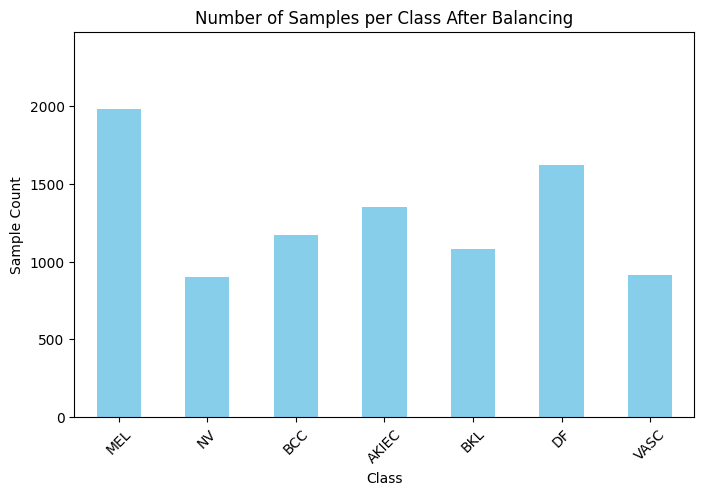

In [ ]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [ ]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),# Data aug: rotation
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training: # Data aug
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224]) # Image resizing
    image = image / 255.0 # Pixel Normalising
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [ ]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [ ]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [ ]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### ResNet152V2
Pre-trained ResNet152V2 followed by Global Average Pooling and 2 Dense layers with batch normalisation and dropout each.<br><br>
**Loss**: categorical cross-entropy<br>
**Batch size**: 32<br>

In [ ]:
def build_model(hp):
    base_model = tf.keras.applications.ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hp.Int('dense_1_units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1))(x)

    x = layers.Dense(hp.Int('dense_2_units', min_value=256, max_value=1024, step=128), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.7, step=0.1))(x)

    outputs = layers.Dense(7, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-6, max_value=1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Tuner for Optmisation
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='bayesian_tuning',
    project_name='skin_lesion_resnet152'
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Perform Bayesian Optmisation to encounter the best hyperparameters for the model
tuner.search(df_train, epochs=10, validation_data=df_validate, class_weight=class_weight_idx)
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 26m 26s]
val_accuracy: 0.7823834419250488

Best val_accuracy So Far: 0.8238341808319092
Total elapsed time: 07h 47m 34s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1046 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
print("Best Hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
dense_1_units: 1536
dropout_1: 0.6000000000000001
dense_2_units: 384
dropout_2: 0.5
lr: 2.8635123152145392e-05


In [ ]:
model_save_name = 'modelRN152V2wWeights_BayOp_BestModel.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
best_model.save(path)

#### Best Model
Best model further training and evaluation

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
histRN152 = best_model.fit(df_train,initial_epoch=10,epochs=30,validation_data=df_validate,class_weight=class_weight_idx,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 11/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 473s 293ms/step - accuracy: 0.6957 - loss: 0.9404 - val_accuracy: 0.7979 - val_loss: 0.7351 - learning_rate: 2.8635e-05
Epoch 12/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 115s 99ms/step - accuracy: 0.7199 - loss: 0.8312 - val_accuracy: 0.8290 - val_loss: 0.6303 - learning_rate: 2.8635e-05
Epoch 13/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 114s 98ms/step - accuracy: 0.7348 - loss: 0.7720 - val_accuracy: 0.7824 - val_loss: 0.7161 - learning_rate: 2.8635e-05
Epoch 14/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 114s 99ms/step - accuracy: 0.7467 - loss: 0.7342 - val_accuracy: 0.7358 - val_loss: 0.8345 - learning_rate: 2.8635e-05
Epoch 15/30
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7640 - loss: 0.6825
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.4317561181087513e-05.
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 113s 98ms/step - accuracy: 0.7640 - loss: 0.6825 - val_accuracy: 0.7876 - val_loss: 0.7011 - learning_rate: 2.8635e-05
Epoch 16/30
1127/1127 ━━━━━━━━━━━

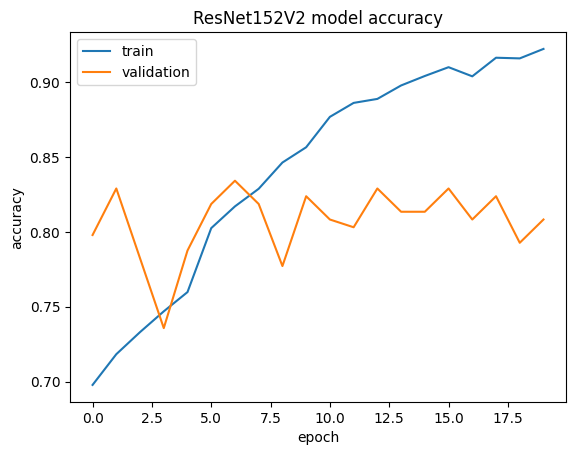

In [ ]:
plot_hist(histRN152, "ResNet152V2")

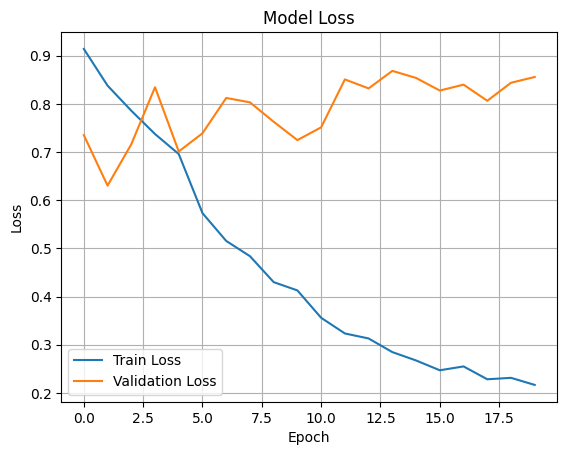

In [ ]:
plt.plot(histRN152.history['loss'], label='Train Loss')
plt.plot(histRN152.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


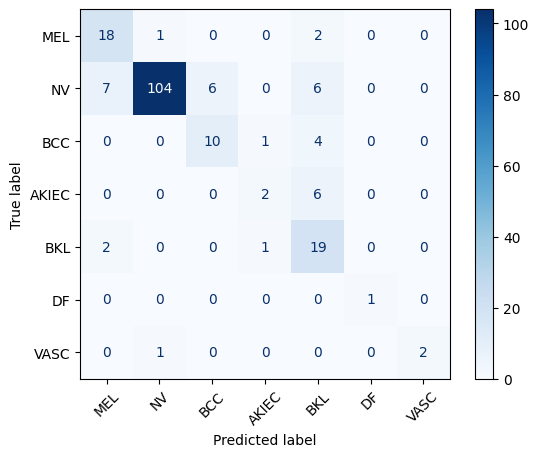

In [ ]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
test_loss, *test_metrics = best_model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.8045 - loss: 0.6932
Test Loss: 0.8612005114555359
Test Metrics: [0.7744709253311157]


In [ ]:
model_save_name = 'modelRN152V2wWeights_BayOp_Final.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
best_model.save(path)